# K-Means Clustering for MNIST Digit Classification

## Introduction
In this notebook, we will explore the use of K-Means clustering for image classification using the MNIST dataset. K-Means is typically used for clustering, but it can also be applied to image analysis tasks. We'll leverage scikit-learn for the implementation. Using PyTorch and the MNIST dataset, we'll delve into the world of K-means clustering for computer vision.

## Required Packages
- PyTorch
- NumPy
- Matplotlib
- Scikit-learn

Let's start by importing the necessary Python packages:



In [1]:
import sys
import sklearn
import numpy as np
import torch
import torchvision.datasets as datasets
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score

## Load Datasets:
We'll start by loading the MNIST dataset, a popular dataset for handwritten digit recognition.

In [2]:
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_dataset = datasets.MNIST(root='./data', train=False)

# Check dataset dimensions
print("Training data shape:", train_dataset.data.shape)
print("Test data shape:", test_dataset.data.shape)


100%|██████████| 9912422/9912422 [00:00<00:00, 146987510.23it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 25284010.40it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42480644.45it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14699482.07it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training data shape: torch.Size([60000, 28, 28])
Test data shape: torch.Size([10000, 28, 28])


## Preprocessing:
We'll reshape the images and normalize pixel values to prepare the data for clustering.

In [3]:
# Reshape images to 1D arrays
# def reshape_images(dataset):
#     return dataset.view(len(dataset), -1)

# train_data = reshape_images(mnist_train.data)
# test_data = reshape_images(mnist_test.data)

# # Normalize pixel values to the range [0, 1]
# train_data = train_data.float() / 255.0

X_train = train_dataset.data.numpy().reshape(len(train_dataset), -1).astype(np.float32) / 255.
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy().reshape(len(test_dataset), -1).astype(np.float32) / 255.
y_test = test_dataset.targets.numpy()
# Check dataset dimensions
print("Training data shape:", X_train.shape, y_train.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Training data shape: (60000, 784) (60000,)
Test data shape: (10000, 784) (10000,)


## Find clusters

The elbow method helps us identify the point at which the within-cluster sum of squares (inertia) starts to level off. This point signifies a reasonable number of clusters for our data. We calculate the inertia for a range of cluster counts and observe the 'elbow' point on the graph.


In [ ]:
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Determine the number of clusters using the elbow method
inertia_values = []
possible_clusters = range(2, 500)  # Try different numbers of clusters (computation time may vary)
for n_clusters in possible_clusters:
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(X_train)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow method graph
plt.figure(figsize=(10, 5))
plt.plot(possible_clusters, inertia_values, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.grid(True)
plt.show()

## Applying K-means Clustering:
We'll apply the K-means clustering algorithm to the preprocessed data. To speed up the process, we'll use the MiniBatchKMeans implementation from Scikit-learn.

In [12]:
# Determine the number of clusters
n_clusters = len(np.unique(y_train)) # 10 clusters

# Apply K-means clustering
kmeans = MiniBatchKMeans(n_clusters=n_clusters, n_init='auto')
kmeans.fit(X_train)

MiniBatchKMeans(n_clusters=10, n_init='auto')

## Infer Cluster Labels:
We'll associate the most probable label with each cluster using the following function:

In [44]:
# def infer_cluster_labels(kmeans, actual_labels):
#     inferred_labels = {}

#     for i in range(kmeans.n_clusters):
#         labels = []
#         index = torch.where(torch.tensor(kmeans.labels_) == i)
#         labels.append(actual_labels[index].tolist())  # Convert to list

#         if len(labels[0]) == 1:
#             counts = torch.bincount(torch.tensor(labels[0]))
#         else:
#             counts = torch.bincount(torch.tensor(labels[0]))

#         inferred_labels[torch.argmax(counts).item()] = i

#     return inferred_labels

# cluster_labels = infer_cluster_labels(kmeans, mnist_train.targets.numpy())

In [13]:
# Function to infer cluster labels
def infer_cluster_labels(kmeans, actual_labels):
    inferred_labels = {}
    for i in range(kmeans.n_clusters):
        labels = []
        index = np.where(kmeans.labels_ == i)
        labels.append(actual_labels[index])
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))
        if np.argmax(counts) in inferred_labels:
            inferred_labels[np.argmax(counts)].append(i)
        else:
            inferred_labels[np.argmax(counts)] = [i]
    return inferred_labels

# Function to infer data labels
def infer_data_labels(X_labels, cluster_labels):
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
    return predicted_labels

## Evaluate Clustering:
We can evaluate the performance of our clustering using metrics like inertia and homogeneity.

In [14]:
# Lists to store training metrics
train_accuracies = []
homogeneity_list = []
inertia_list = []

# Apply K-means clustering
clusters = [10, 50, 100, 250, 300]

from sklearn.metrics import homogeneity_score
for n_clusters in clusters:
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, n_init='auto')
    kmeans.fit(X_train)

    inertia = kmeans.inertia_
    homogeneity = homogeneity_score(y_train, kmeans.labels_)

    inertia_list.append(inertia)
    homogeneity_list.append(homogeneity)

    # Function to infer cluster labels
    def infer_cluster_labels(kmeans, actual_labels):
        inferred_labels = {}
        for i in range(kmeans.n_clusters):
            labels = []
            index = np.where(kmeans.labels_ == i)
            labels.append(actual_labels[index])
            if len(labels[0]) == 1:
                counts = np.bincount(labels[0])
            else:
                counts = np.bincount(np.squeeze(labels))
            if np.argmax(counts) in inferred_labels:
                inferred_labels[np.argmax(counts)].append(i)
            else:
                inferred_labels[np.argmax(counts)] = [i]
        return inferred_labels

    # Function to infer data labels
    def infer_data_labels(X_labels, cluster_labels):
        predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
        for i, cluster in enumerate(X_labels):
            for key, value in cluster_labels.items():
                if cluster in value:
                    predicted_labels[i] = key
        return predicted_labels

    cluster_labels = infer_cluster_labels(kmeans, y_train)
    prediction = infer_data_labels(kmeans.labels_, cluster_labels)
    acc = accuracy_score(y_train, prediction)

    # Store training accuracy
    train_accuracies.append(acc)

    # Print the accuracy for the current number of clusters
    print(f'Number of Clusters: {n_clusters}')
    print(f'Accuracy: {acc}\n')

Number of Clusters: 10
Accuracy: 0.5040666666666667

Number of Clusters: 50
Accuracy: 0.7862666666666667

Number of Clusters: 100
Accuracy: 0.8587166666666667

Number of Clusters: 250
Accuracy: 0.9005833333333333

Number of Clusters: 300
Accuracy: 0.9081833333333333



# Visualize the results

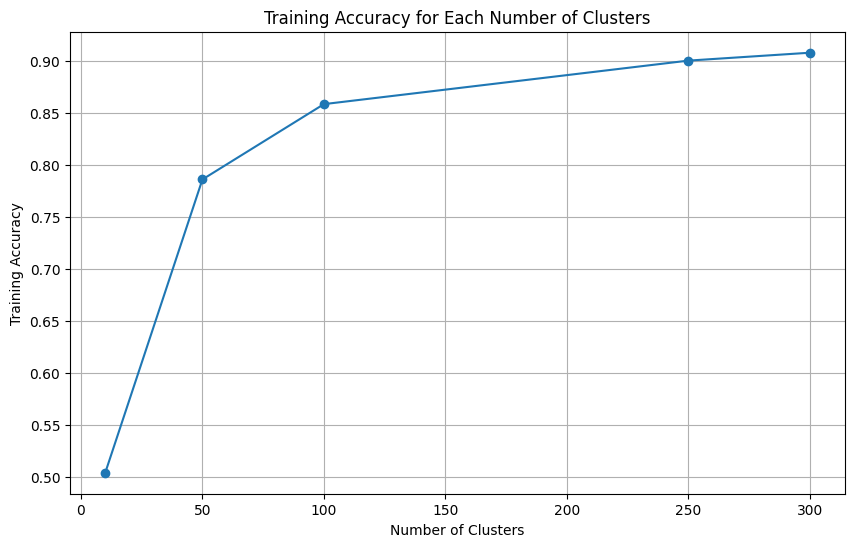

In [15]:
# Visualize the results
# Plot the accuracy of training for each num_cluster
plt.figure(figsize=(10, 6))
plt.plot(clusters, train_accuracies, marker='o')
plt.title('Training Accuracy for Each Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Training Accuracy')
plt.grid(True)
plt.show()

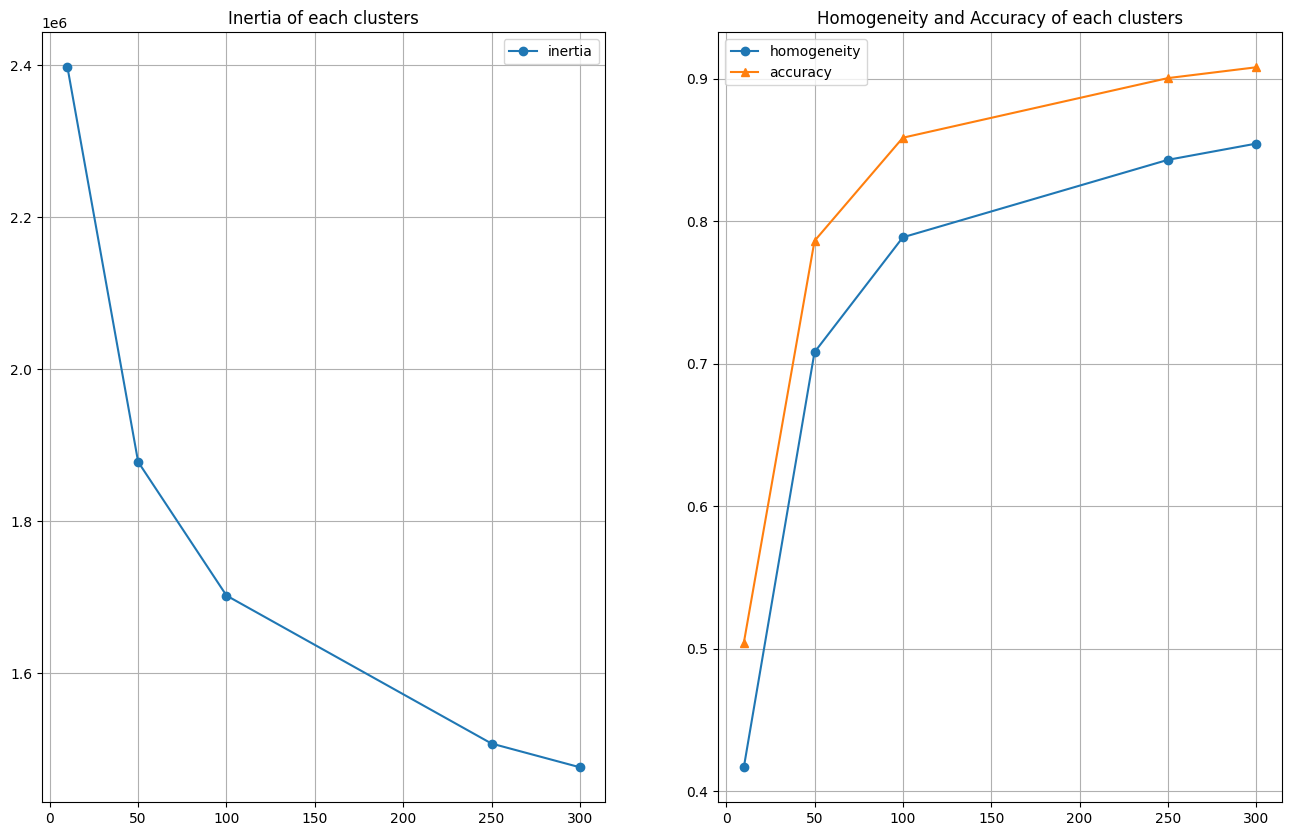

In [16]:
# Visualize results
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].plot(clusters, inertia_list, label='inertia', marker='o')
ax[1].plot(clusters, homogeneity_list, label='homogeneity', marker='o')
ax[1].plot(clusters, train_accuracies, label='accuracy', marker='^')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[0].grid('on')
ax[1].grid('on')
ax[0].set_title('Inertia of each clusters')
ax[1].set_title('Homogeneity and Accuracy of each clusters')
plt.show()

## Test

In [62]:
# Test dataset
kmeans = MiniBatchKMeans(n_clusters=250,n_init='auto')
kmeans.fit(X_test)
cluster_labels = infer_cluster_labels(kmeans, y_test)
test_clusters = kmeans.predict(X_test)
prediction = infer_data_labels(kmeans.predict(X_test), cluster_labels)
accuracy = accuracy_score(y_test, prediction)
print('Test Accuracy: {}'.format(accuracy))


Test Accuracy: 0.9023


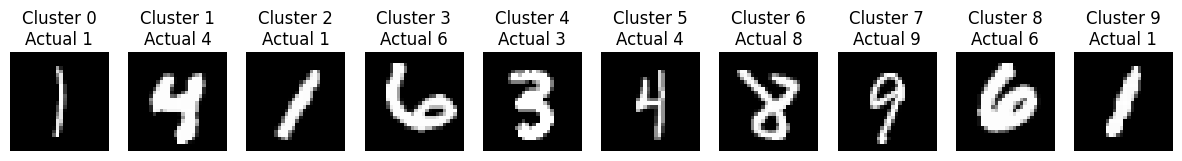

In [63]:
# Plot some examples of inferred images along with their labels
num_examples_to_plot = 10  # Adjust this to the number of examples you want to plot

fig, axs = plt.subplots(1, num_examples_to_plot, figsize=(15, 2))

for i in range(num_examples_to_plot):
    # Find an image with the cluster label
    cluster_label = i  # Change this to the cluster label you want to visualize
    index = np.where(test_clusters == cluster_label)[0][0]

    # Plot the image
    axs[i].imshow(X_test[index].reshape(28, 28), cmap='gray')
    axs[i].set_title(f'Cluster {cluster_label}\nActual {y_test[index]}')
    axs[i].axis('off')

plt.show()

We explored K-means clustering for image analysis using PyTorch. We preprocessed the data, applied K-means clustering, and evaluated the clustering performance. K-means clustering is a powerful technique for image analysis and can be a valuable addition to your machine learning toolbox.

## PCA for data visualization

In [5]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Load the MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
]))

mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]))

# Define the size of the subset (e.g., first 1000 samples)
subset_size = 2000

# Get a subset of the data and labels
X_train = mnist_train.data[:subset_size].numpy().reshape(subset_size, -1).astype(np.float32) / 255.
y_train = mnist_train.targets[:subset_size].numpy()

# # Get the data and labels
# X_train = mnist_train.data.numpy().reshape(len(mnist_train), -1).astype(np.float32) / 255.
# y_train = mnist_train.targets.numpy()

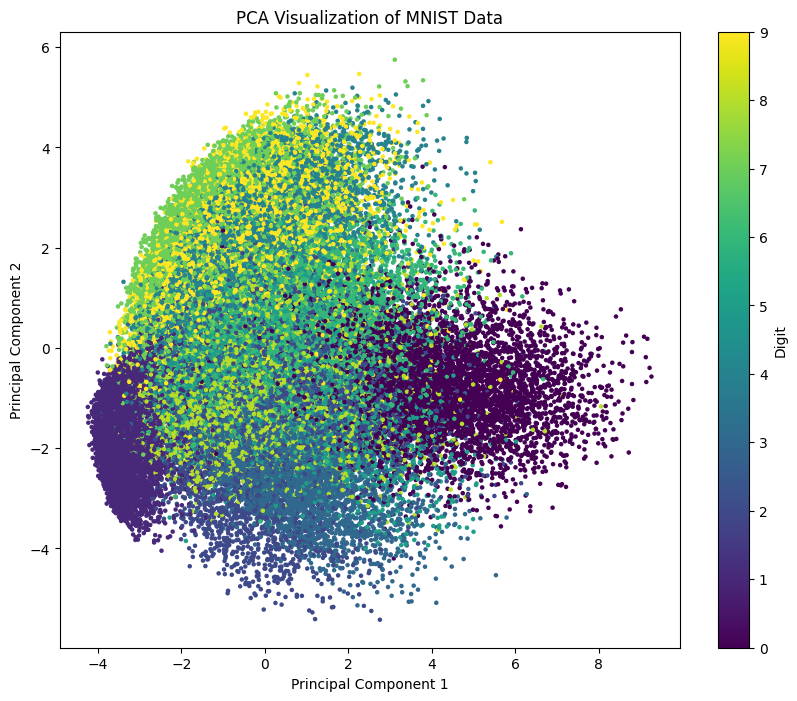

In [65]:
# Import necessary libraries
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA for visualization
pca = PCA(n_components=2)
train_data_pca = pca.fit_transform(X_train)

# Plot the first two principal components
plt.figure(figsize=(10, 8))
plt.scatter(train_data_pca[:, 0], train_data_pca[:, 1], c=mnist_train.targets.numpy(), cmap='viridis', s=5)
plt.colorbar(label='Digit')
plt.title('PCA Visualization of MNIST Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


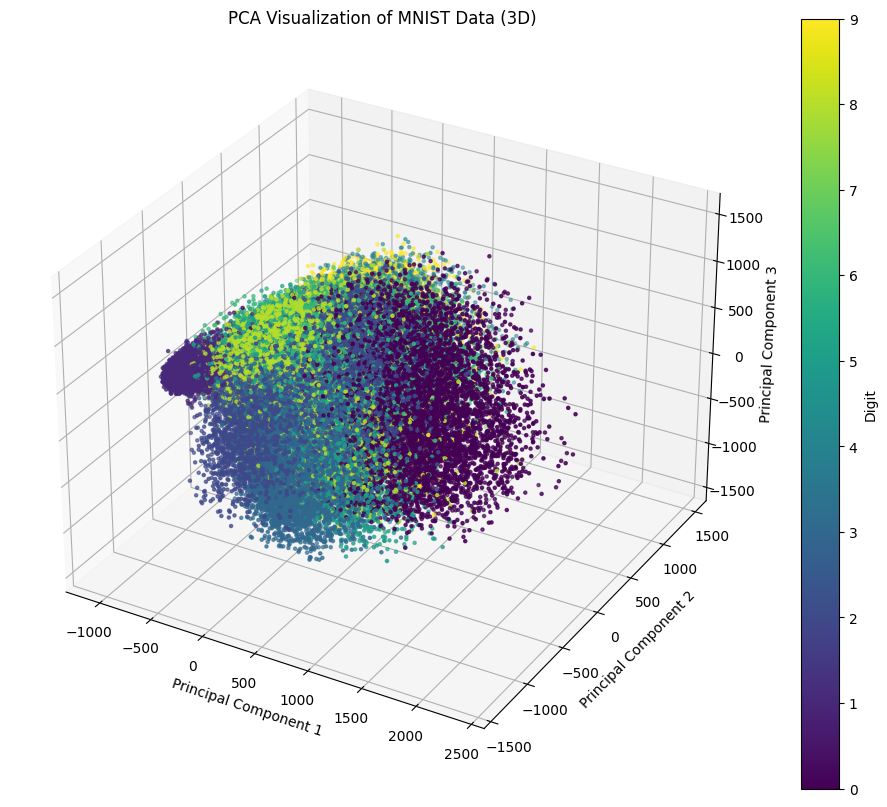

In [ ]:
# Import necessary libraries
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Perform PCA for visualization with 3 components
pca = PCA(n_components=3)
train_data_pca = pca.fit_transform(X_train)

# Plot the first three principal components in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(train_data_pca[:, 0], train_data_pca[:, 1], train_data_pca[:, 2], c=mnist_train.targets.numpy(), cmap='viridis', s=5)
plt.colorbar(scatter, label='Digit')
ax.set_title('PCA Visualization of MNIST Data (3D)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()


# t-SNE for data visualization

This code will load the MNIST dataset, perform t-SNE dimensionality reduction on the training data, and visualize the results in a 2D scatter plot with colors representing the different digit classes. Adjust the n_components parameter in TSNE to control the number of dimensions in the reduced space if needed.

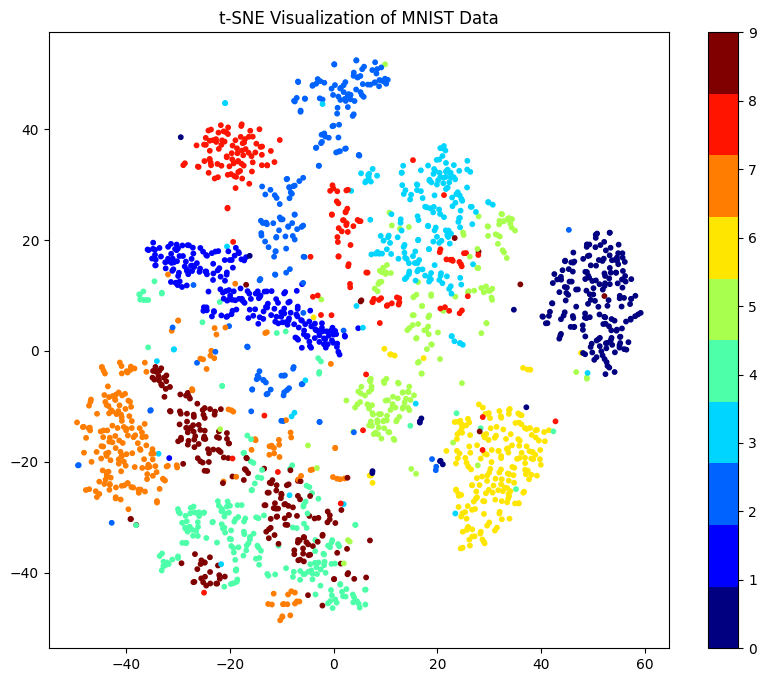

In [9]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train)

# Visualize the results
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap=plt.get_cmap('jet', 10), marker='o', s=10)
plt.colorbar()
plt.title('t-SNE Visualization of MNIST Data')
plt.show()

## UMAP for data visualization

This code will load the MNIST dataset, perform UMAP dimensionality reduction on the training data, and visualize the results in a 2D scatter plot with colors representing the different digit classes. Adjust the n_components parameter in UMAP to control the number of dimensions in the reduced space if needed.

To perform dimensionality reduction using UMAP (Uniform Manifold Approximation and Projection) on the MNIST dataset, you'll need to install the umap-learn library if you haven't already. You can install it using pip

In [1]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 950.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82808 sha256=69a7543c9fdc5b3067083d23283d3c29d14bc1a977626cb04175b7ad4db3607f
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55617 sha256=228222c45a4febd34ef65ee31344173a5bfb5b8ece42ef5c7a43855a593186b4
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


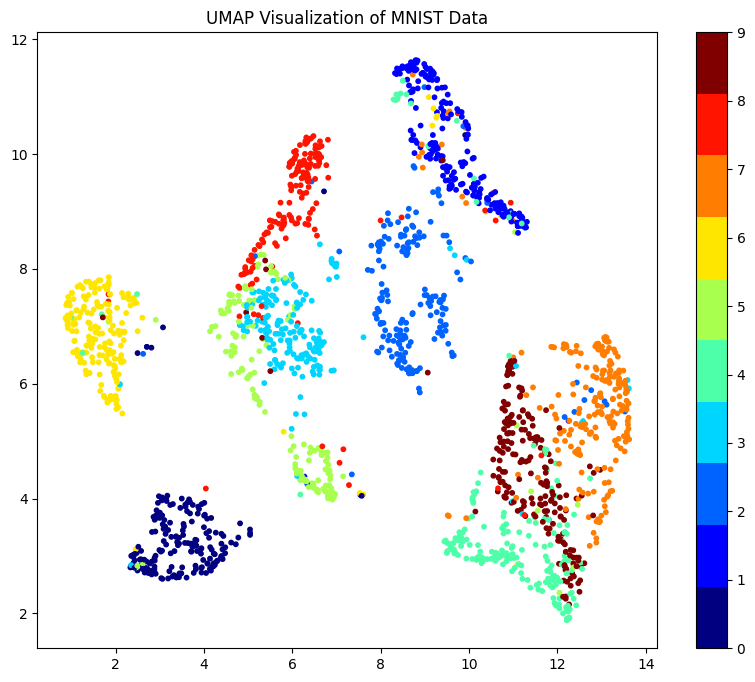

In [4]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import umap
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True)

# Define the size of the subset (e.g., first 1000 samples)
subset_size = 2000

# Get a subset of the data and labels
X_train = mnist_train.data[:subset_size].numpy().reshape(subset_size, -1).astype(np.float32) / 255.
y_train = mnist_train.targets[:subset_size].numpy()

# # Get the data and labels
# X_train = mnist_train.data.numpy().reshape(len(mnist_train), -1).astype(np.float32) / 255.
# y_train = mnist_train.targets.numpy()

# Perform UMAP dimensionality reduction
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_train)

# Visualize the results
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_train, cmap=plt.get_cmap('jet', 10), marker='o', s=10)
plt.colorbar()
plt.title('UMAP Visualization of MNIST Data')
plt.show()


Adapted from:

*   https://www.kaggle.com/code/ngbolin/mnist-dataset-digit-recognizer/notebook
*   https://github.com/sharmaroshan/MNIST-Using-K-means/blob/master/KMeans%20Clustering%20for%20Imagery%20Analysis%20(Jupyter%20Notebook).ipynb
*   https://medium.datadriveninvestor.com/k-means-clustering-for-imagery-analysis-56c9976f16b6

